In [293]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [294]:
results = pd.read_csv('./results/results_bcast_full.csv')
print(results.columns, results.shape)
results.head()

Index(['Size', 'Avg Latency(us)', 'Min Latency(us)', 'Max Latency(us)',
       'Iterations', 'NP_total', 'ALGO', 'ALGO_NAME'],
      dtype='object') (640, 8)


,Size,Avg Latency(us),Min Latency(us),Max Latency(us),Iterations,NP_total,ALGO,ALGO_NAME
0,1,1.73,0.11,3.36,30000,2,0,default
1,2,1.72,0.10,3.33,30000,2,0,default
2,4,1.73,0.10,3.36,30000,2,0,default
3,8,1.74,0.11,3.37,30000,2,0,default
4,16,1.79,0.11,3.46,30000,2,0,default


# 3D Heatmap

In [295]:
results['ALGO_NAME'].unique()

array(['default', 'chain', 'pipeline', 'binary tree'], dtype=object)

/tmp/ipykernel_62936/1571706649.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


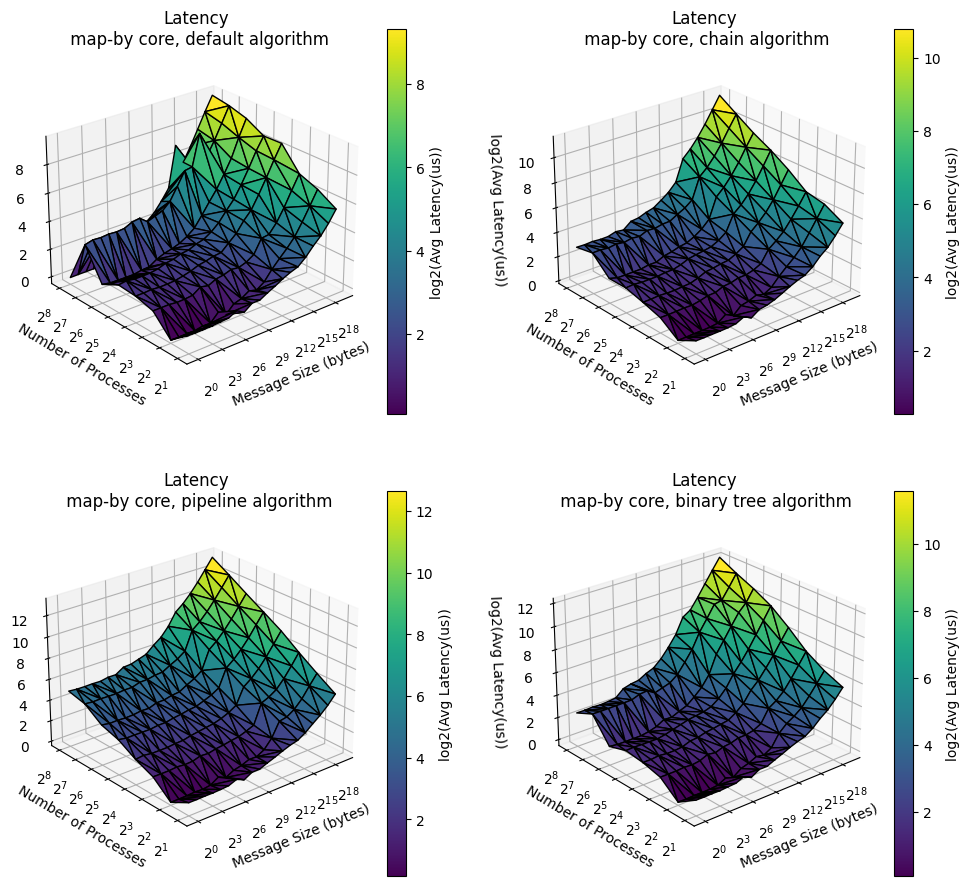

In [296]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a single subplot with 2 columns
fig = plt.figure(figsize=(12, 11))

for i, ALGO in enumerate(results['ALGO_NAME'].unique(), start=1):
    # Select data for the current algorithm
    algorithm_data = results[results['ALGO_NAME'] == ALGO]

    # Extract relevant columns
    x = algorithm_data['Size']
    y = algorithm_data['NP_total']
    z = algorithm_data['Avg Latency(us)']

    # Add subplot for the current algorithm
    ax = fig.add_subplot(2, 2, i, projection='3d')

    # Plot the 3D mesh heatmap for the current algorithm
    mesh = ax.plot_trisurf(np.log2(x), np.log2(y), np.log2(z), cmap='viridis', edgecolor='k')

    # Set labels
    ax.set_xlabel('Message Size (bytes)')
    ax.set_ylabel('Number of Processes')
    ax.set_zlabel('log2(Avg Latency(us))')

    ax.set_title(f'Latency\n map-by core, {ALGO} algorithm')

    # Set y-axis tick labels
    yticks_values = [2, 4, 8, 16, 32, 64, 128, 256]
    yticks_labels = ['$2^{%s}$' % int(np.log2(val)) for val in yticks_values]
    ax.set_yticks(np.log2(yticks_values))
    ax.set_yticklabels(yticks_labels)

    # Set x-axis tick labels
    xticks_labels = ['$2^{%s}$' % int(val) for val in np.log2(x.unique())]
    ax.set_xticks(np.log2(x.unique())[::3])
    ax.set_xticklabels(xticks_labels[::3])

    # Add colorbar
    cbar = fig.colorbar(mesh, ax=ax, label='log2(Avg Latency(us))')
    ax.view_init(elev=25, azim=-130)  # Adjust the elevation and azimuth angles as needed

# Adjust subplot layout
fig.tight_layout()

# Show the plot
plt.show()


# Simple model

In [297]:
import math

def succ_left(p):
  h = math.floor(math.log2(p+1))
  if h == 0:
    i = 0
  else:
    i = 2*(p-2**h+1) + p//(2**(h+1)-2)
  return 2**(h+1) - 1 + i

def succ_right(p):
  h = math.floor(math.log2(p+1))
  if h == 0:
    i = 0
  else:
    i = 2*(p-2**h+1) + p//(2**(h+1)-2)
  return 2**h + 2**(h+1) - 1 + i

In [298]:
import matplotlib.pyplot as plt


# The main problem is different latencies between different cores based on CCD / CCX / numa region / socket / node
# CCX -> sets of 4 core complexes sharing same l3

# Each CPU has 64 cores organized in 8 different CCD (Core Complex Die), each couple of closest CCD represent a NUMA region.
# Each CCD contain 2 CCX (Core Complex) with 4 cores each, they share same L3 cache.


# All measured in microseconds (1e^-6)
LATENCY_CCX = 0.15e-6
LATENCY_CCD_DIFF_CCX = 0.31e-6
LATENCY_NUMA = 0.34e-6
LATENCY_SOCKET = 0.36e-6
LATENCY_DIFF_SOCKET = 0.65e-6
LATENCY_DIFF_NODE = 1.82e-6

# Sizes
CCX = 4
NUMA = 16
SAME_SOCKET = 32
SOCKET = 64
NODE = 128

CHAIN_TIMES = np.zeros((255,), dtype=np.float32)
for i in range(255):
  j = i+1
  if i // CCX == j // CCX: CHAIN_TIMES[i] = LATENCY_CCX
  elif i // NUMA == j // NUMA: CHAIN_TIMES[i] = LATENCY_CCD_DIFF_CCX
  elif i // SAME_SOCKET == j // SAME_SOCKET: CHAIN_TIMES[i] = LATENCY_NUMA
  elif i // SOCKET == j // SOCKET: CHAIN_TIMES[i] = LATENCY_SOCKET
  elif i // NODE == j // NODE: CHAIN_TIMES[i] = LATENCY_DIFF_SOCKET
  else: CHAIN_TIMES[i] = LATENCY_DIFF_NODE

MATRIX_TIMES = np.zeros((255, 255), dtype=np.float32)
for i in range(255):
  for j in range(255):
    if i == j:
      MATRIX_TIMES[i][j] = 0
    elif i//4 == j//4:
      MATRIX_TIMES[i][j] = LATENCY_CCX
    elif i//16 == j//16:
      MATRIX_TIMES[i][j] = LATENCY_CCD_DIFF_CCX
    elif i//32 == j//32:
      MATRIX_TIMES[i][j] = LATENCY_NUMA
    elif i//64 == j//64:
      MATRIX_TIMES[i][j] = LATENCY_SOCKET
    elif i//128 == j//128:
      MATRIX_TIMES[i][j] = LATENCY_DIFF_SOCKET
    else:
      MATRIX_TIMES[i][j] = LATENCY_DIFF_NODE

# pipeline (which is chain) latency
# small message so no splitting requires same number of steps as number of nodes
# as cores are mapped first on node1 and then on node2 we can assume
# a single communication between the two nodes with higher latency and a lot
# more communications intranode
def pipeline_latency(num_proc):
    # latency in node
    proc_in_node = (num_proc // 2)
    time = 0
    for j in range(1, proc_in_node):
        time += 2 * CHAIN_TIMES[j - 1]
    time += LATENCY_DIFF_NODE
    return time

NON_OVERLAP_FACTOR = 0.4e-2
TOTAL_PROC_FACTOR = 1.5e-4 * 1e-6
def bin_tree_latency(n_proc):
    time = 0
    for j in range(1, math.floor(math.log2(n_proc)) + 1):
        step_j = []
        for k in range(j - 1, math.floor(math.log2(n_proc))):
            left = succ_left(k)
            right = succ_right(k)
            step_j.append(MATRIX_TIMES[k][left] + MATRIX_TIMES[k][right])
        time += max(step_j) + 2**(j + 1) * NON_OVERLAP_FACTOR * max(step_j)
    time += n_proc**2 * TOTAL_PROC_FACTOR
    return time

n_proc = list(range(1, 253))

# Calculate estimated latency for each number of processors
est_lat_pipeline = np.array([pipeline_latency(N) for N in n_proc])
est_lat_pipeline *= 10**6

est_lat_bin_tree = np.array([bin_tree_latency(N) for N in n_proc])
est_lat_bin_tree *= 10**6

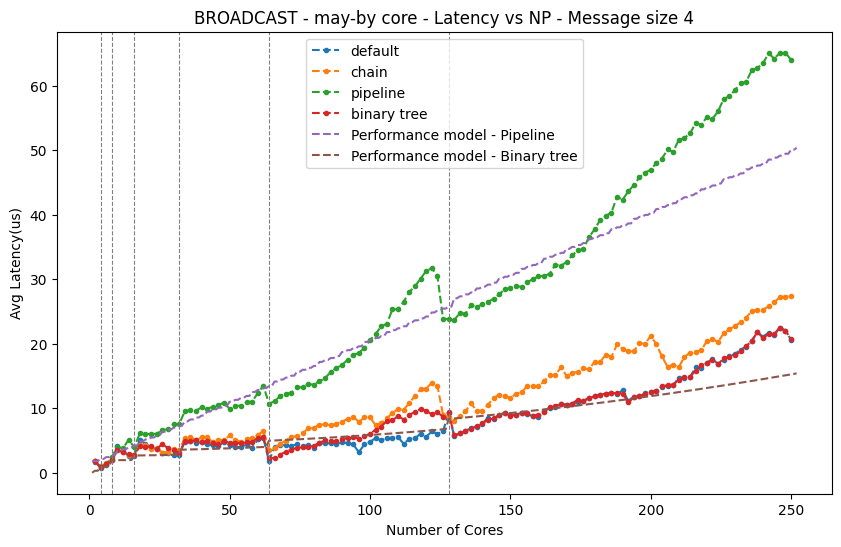

In [304]:
results = pd.read_csv('./results/results_bcast_fixedsize.csv')
results = results[results['NP_total'] < 252]  # erratic behaviour for last few

# Extract relevant columns
cores = results['NP_total']
latency = results['Avg Latency(us)']
algo_names = results['ALGO_NAME'].unique()

# Create a line plot with vertical lines
fig, ax = plt.subplots(figsize=(10, 6))

MESSAGE_SIZE = 4

# Plot for each algorithm
for algo_name in algo_names:
    algo_data = results[(results['ALGO_NAME'] == algo_name) & (results['Size'] == MESSAGE_SIZE)]
    ax.plot(algo_data['NP_total'], algo_data['Avg Latency(us)'], '--o', markersize=3, label=algo_name)

ax.plot(n_proc, est_lat_pipeline, '--', label='Performance model - Pipeline')
ax.plot(n_proc, est_lat_bin_tree, '--', label='Performance model - Binary tree')

# Add vertical lines for specific numbers of processors
vertical_lines = [4, 8, 32, 16, 64, 128]
for line in vertical_lines:
    ax.axvline(x=line, color='gray', linestyle='--', linewidth=0.8)

# Set labels and title
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Avg Latency(us)')
ax.set_title(f'BROADCAST - may-by core - Latency vs NP - Message size {MESSAGE_SIZE}')

ax.legend()
plt.show()

In [301]:
def linear_latency(num_proc):
    time = 0
    for j in range(1, num_proc):
        time += MATRIX_TIMES[0, j]
    return time

# def linear_latency(num_proc):
#     proc_in_node = (num_proc // 2)
#     time = 0
#     for j in range(1, proc_in_node):
#         time += 2 * CHAIN_TIMES[j - 1]
#     time += LATENCY_DIFF_NODE
#     return time

NON_OVERLAP_FACTOR = 0.4e-2
TOTAL_PROC_FACTOR = 1.5e-4 * 1e-6
def bin_tree_latency(n_proc):
    time = 0
    for j in range(1, math.floor(math.log2(n_proc)) + 1):
        step_j = []
        for k in range(j - 1, math.floor(math.log2(n_proc))):
            left = succ_left(k)
            right = succ_right(k)
            step_j.append(MATRIX_TIMES[k][left] + MATRIX_TIMES[k][right])
            # step_j.append(MATRIX_TIMES[k][left])
            # step_j.append(MATRIX_TIMES[k][right])
        time += max(step_j) + 2**(j + 1) * NON_OVERLAP_FACTOR * max(step_j)
    time += n_proc**2 * TOTAL_PROC_FACTOR
    return time

n_proc = list(range(1, 253))

# Calculate estimated latency for each number of processors
est_lat_linear = np.array([linear_latency(N) for N in n_proc])
est_lat_linear *= 10**6

est_lat_bin_tree = np.array([bin_tree_latency(N) for N in n_proc])
est_lat_bin_tree *= 10**6

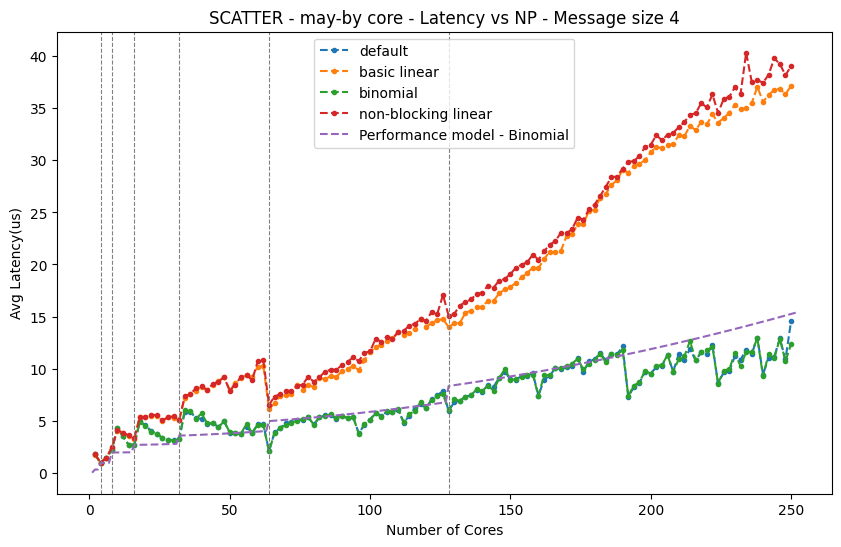

In [302]:
results = pd.read_csv('./results/results_scatter_fixedsize.csv')
results = results[results['NP_total'] < 252]

# Extract relevant columns
cores = results['NP_total']
latency = results['Avg Latency(us)']
algo_names = results['ALGO_NAME'].unique()

# Create a line plot with vertical lines
fig, ax = plt.subplots(figsize=(10, 6))

MESSAGE_SIZE = 4

# Plot for each algorithm
for algo_name in algo_names:
    algo_data = results[(results['ALGO_NAME'] == algo_name) & (results['Size'] == MESSAGE_SIZE)]
    ax.plot(algo_data['NP_total'], algo_data['Avg Latency(us)'], '--o', markersize=3, label=algo_name)

# ax.plot(n_proc, est_lat_linear, '--', label='Performance model - Linear')
ax.plot(n_proc, est_lat_bin_tree, '--', label='Performance model - Binomial')

# Add vertical lines for specific numbers of processors
vertical_lines = [4, 8, 32, 16, 64, 128]
for line in vertical_lines:
    ax.axvline(x=line, color='gray', linestyle='--', linewidth=0.8)

# Set labels and title
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Avg Latency(us)')
ax.set_title(f'SCATTER - may-by core - Latency vs NP - Message size {MESSAGE_SIZE}')

# ax.set_xticks(n_proc)

ax.legend()
plt.show()